In [1]:
# dependecies
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

## constant velocity model

##################################################
2D acoustic FDTD wave propagation
Isotropic medium with Cerjan (1985) boundary conditions
##################################################
Model:
	401 x 401	grid nz x nx
	1.0e+01 x 1.0e+01	[m] dz x dx
	4.0e+03 x 4.0e+03	[m] model size
	3.0e+03...3.0e+03	[m/s] vp
Time:
 	5.7e-01 	[sec] total
	2.3e-03	dt 
 	246	 time steps
Source:
	1.0e+01	[Hz] dominant frequency
	0.1	[sec] index time
Other:
	0.7	CFL number
	150.00	[m] shortest wavelength
	15, 15	 points-per-wavelength OX, OZ
##################################################
Time step: 0 	 0.0000 s


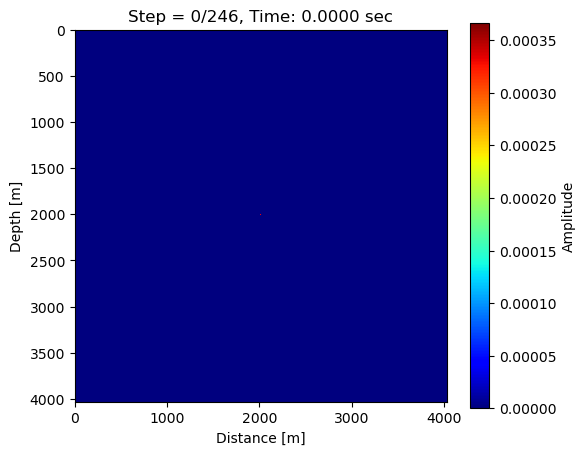

Time step: 20 	 0.0467 s


<Figure size 640x480 with 0 Axes>

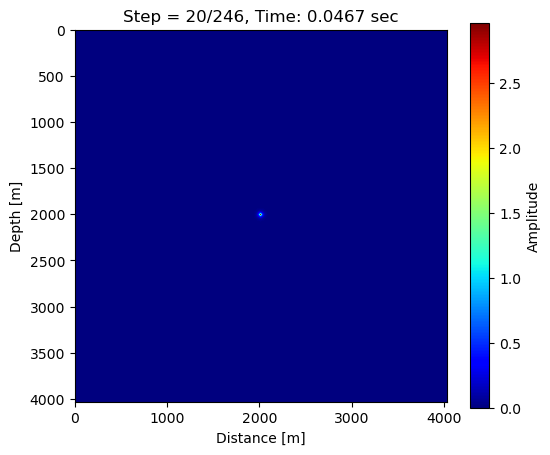

Time step: 40 	 0.0935 s


<Figure size 640x480 with 0 Axes>

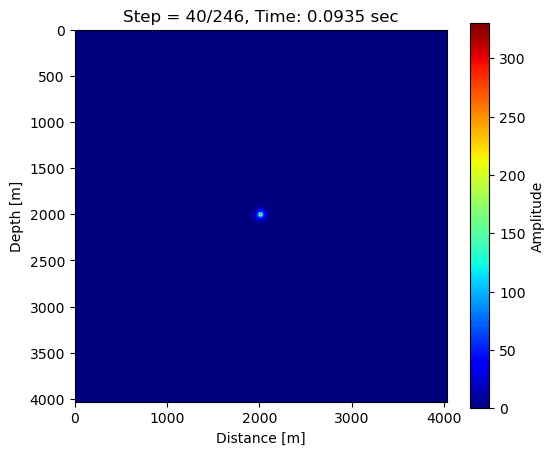

Time step: 60 	 0.1402 s


<Figure size 640x480 with 0 Axes>

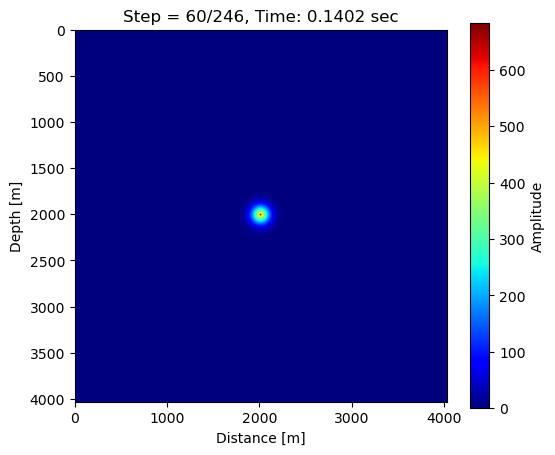

Time step: 80 	 0.1870 s


<Figure size 640x480 with 0 Axes>

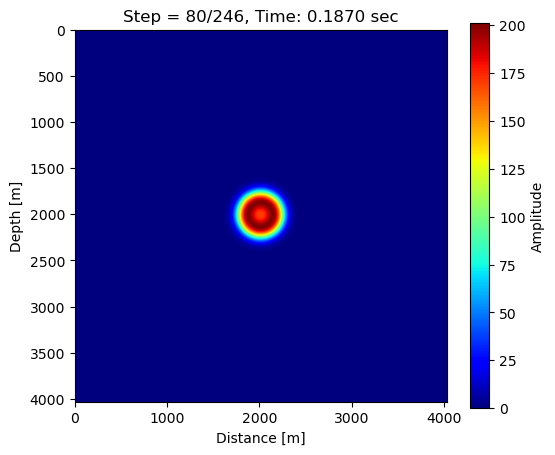

Time step: 100 	 0.2337 s


<Figure size 640x480 with 0 Axes>

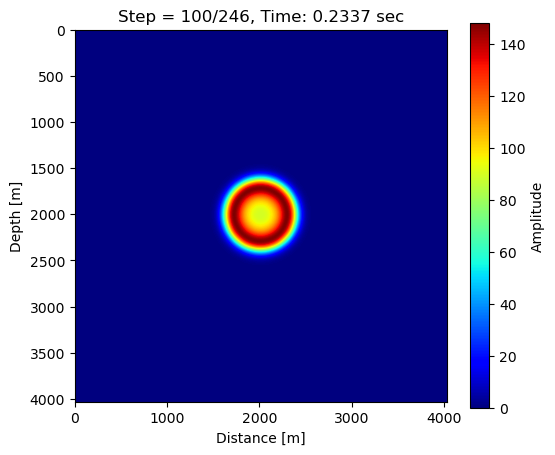

Time step: 120 	 0.2805 s


<Figure size 640x480 with 0 Axes>

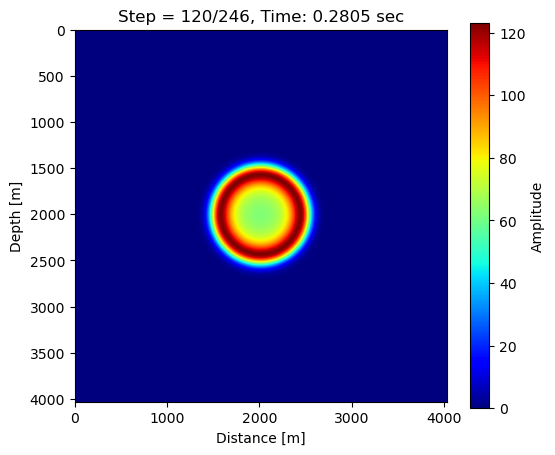

Time step: 140 	 0.3272 s


<Figure size 640x480 with 0 Axes>

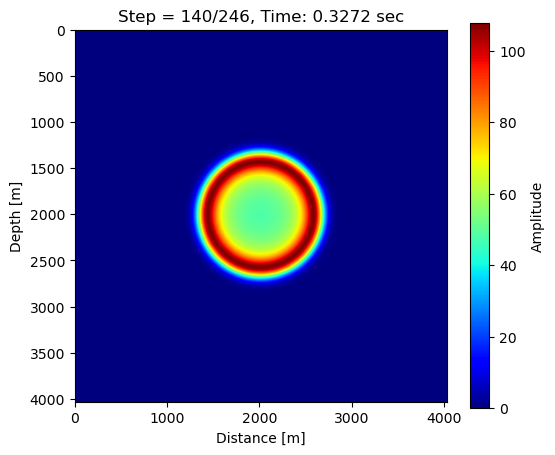

Time step: 160 	 0.3740 s


<Figure size 640x480 with 0 Axes>

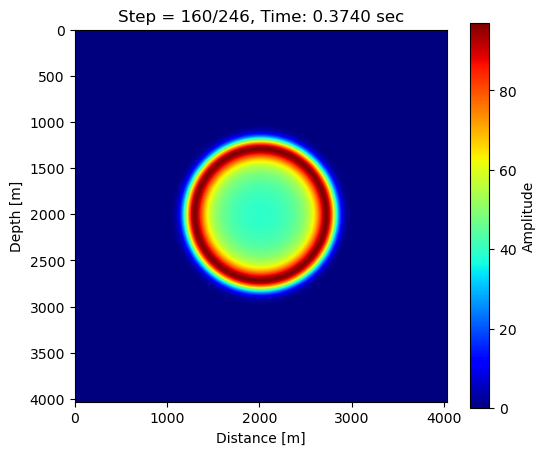

Time step: 180 	 0.4207 s


<Figure size 640x480 with 0 Axes>

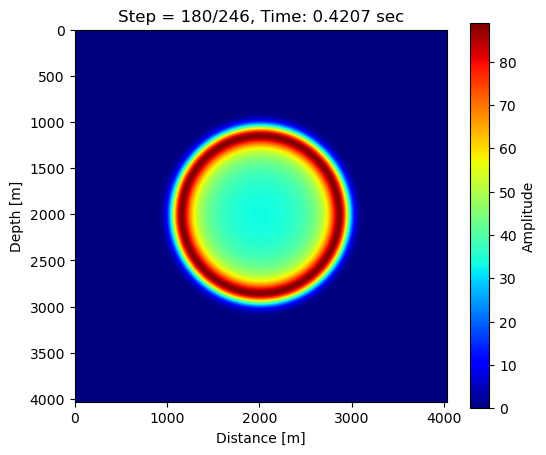

Time step: 200 	 0.4675 s


<Figure size 640x480 with 0 Axes>

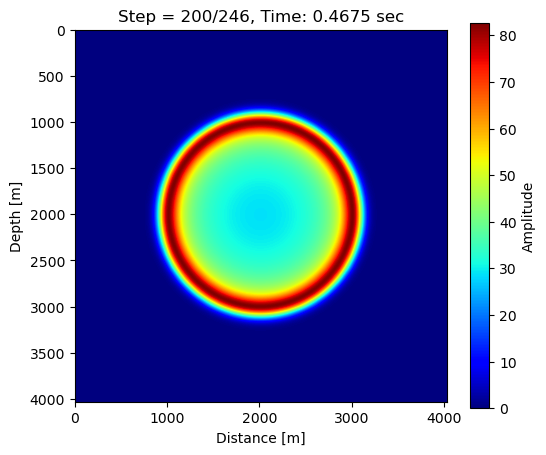

Time step: 220 	 0.5142 s


<Figure size 640x480 with 0 Axes>

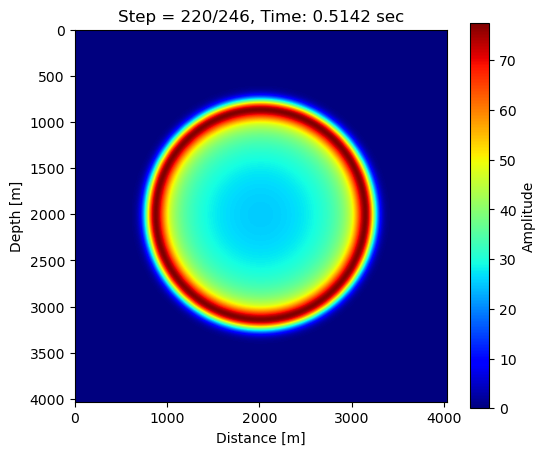

Time step: 240 	 0.5610 s


<Figure size 640x480 with 0 Axes>

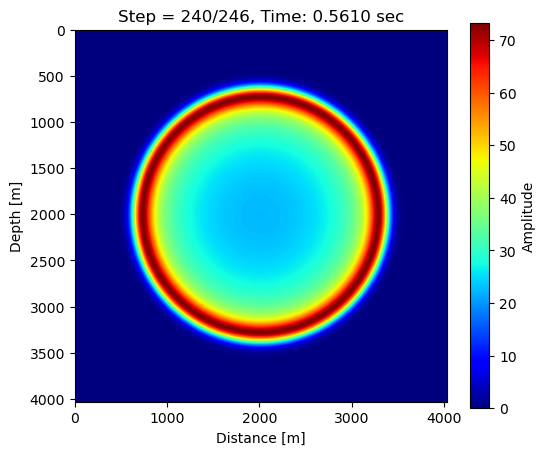

Simulation completed in 6.57 seconds
End


<Figure size 640x480 with 0 Axes>

In [2]:
def acoustic_wave_propagation():
    """
    2D Finite-difference time domain (FDTD) acoustic wave propagation simulation
    with sponge boundary conditions (Cerjan, 1985).
    
    Solves the second-order wave equation in time domain using displacement formulation,
    resulting in pressure wavefield propagation.
    
    The implementation uses:
    - Conventional FD stencils with O(2,2) accuracy
    - Second derivative stencil: [1 -2 1]/dx^2
    - Sponge boundary conditions to absorb outgoing waves
    
    Returns:
        None (displays wavefield animation)
    """
    
    # ======================
    # SIMULATION PARAMETERS
    # ======================
    
    # Output display frequency (show wavefield every IT_DISPLAY steps)
    IT_DISPLAY = 20
    
    # ======================
    # MODEL PARAMETERS
    # ======================
    
    # Model dimensions (grid points)
    nx = 401
    nz = 401
    
    # Grid spacing [m]
    dx = 10.0
    dz = 10.0
    
    # Velocity model (constant velocity for this example) [m/s]
    vp = 3000.0 * np.ones((nz, nx))
    
    # ======================
    # TIME STEPPING PARAMETERS
    # ======================
    
    t_total = 0.575  # Total simulation time [sec]
    
    # Calculate time step based on CFL condition (70% of stability limit)
    dt = 0.7 * min(dx, dz) / np.max(vp)
    
    # Number of time steps
    nt = int(round(t_total / dt))
    
    # Time vector
    t = np.linspace(0, t_total, nt+1)
    
    # Calculate CFL number for stability check
    CFL = np.max(vp) * dt / min(dx, dz)
    
    # ======================
    # SOURCE PARAMETERS
    # ======================
    
    f0 = 10.0  # Dominant frequency of the source wavelet [Hz]
    t0 = 1.20 / f0  # Time delay for source wavelet [sec]
    factor = 1e10  # Amplitude coefficient
    
    # Source position (center of the model)
    jsrc = int(round(nz / 2))
    isrc = int(round(nx / 2))
    
    # Source time function parameters
    a = np.pi**2 * f0**2
    
    # Precompute source time function (Gaussian wavelet)
    source_term = factor * np.exp(-a * (t - t0)**2)
    
    # Alternative source options (commented out):
    # First derivative of Gaussian:
    # source_term = -factor * 2.0 * a * (t - t0) * np.exp(-a * (t - t0)**2)
    # Ricker wavelet (second derivative of Gaussian):
    # source_term = factor * (1.0 - 2.0 * a * (t - t0)**2) * np.exp(-a * (t - t0)**2)
    
    # Scale source term for numerical stability
    force_x = source_term * dt**2 / (dx * dz)
    
    # Calculate minimum wavelength for stability check
    min_wavelength = 0.5 * np.min(vp[vp > 330]) / f0  # shortest wavelength
    
    # ======================
    # ABSORBING BOUNDARY (Cerjan sponge layer)
    # ======================
    
    # Thickness of absorbing boundary layer (15% of model size)
    abs_thick = min(int(0.15 * nx), int(0.15 * nz))
    
    # Decay rate for sponge layer
    abs_rate = 0.3 / abs_thick
    
    # Define margins for left/right boundaries
    lmargin = [abs_thick, abs_thick]
    rmargin = [abs_thick, abs_thick]
    
    # Initialize weights for sponge layer (1 = no absorption)
    weights = np.ones((nz + 2, nx + 2))
    
    # Calculate weights for sponge layer (exponential decay)
    for iz in range(nz + 2):
        for ix in range(nx + 2):
            i = 0
            j = 0
            k = 0
            
            # Check left boundary in x-direction
            if ix < lmargin[0] + 1:
                i = lmargin[0] + 1 - ix
            
            # Check left boundary in z-direction
            if iz < lmargin[1] + 1:
                k = lmargin[1] + 1 - iz
            
            # Check right boundary in x-direction
            if nx - rmargin[0] < ix:
                i = ix - nx + rmargin[0]
            
            # Check right boundary in z-direction
            if nz - rmargin[1] < iz:
                k = iz - nz + rmargin[1]
            
            # If we're in the absorbing layer, calculate weight
            if i != 0 or j != 0 or k != 0:
                rr = abs_rate**2 * float(i**2 + j**2 + k**2)
                weights[iz, ix] = np.exp(-rr)
    
    # ======================
    # SIMULATION SUMMARY
    # ======================
    
    print('#' * 50)
    print('2D acoustic FDTD wave propagation')
    print('Isotropic medium with Cerjan (1985) boundary conditions')
    print('#' * 50)
    print(f'Model:\n\t{nz} x {nx}\tgrid nz x nx')
    print(f'\t{dz:.1e} x {dx:.1e}\t[m] dz x dx')
    print(f'\t{nx*dx:.1e} x {nz*dz:.1e}\t[m] model size')
    print(f'\t{np.min(vp):.1e}...{np.max(vp):.1e}\t[m/s] vp')
    print(f'Time:\n \t{t_total:.1e} \t[sec] total')
    print(f'\t{dt:.1e}\tdt \n \t{nt}\t time steps')
    print(f'Source:\n\t{f0:.1e}\t[Hz] dominant frequency')
    print(f'\t{t0:.1f}\t[sec] index time')
    print(f'Other:\n\t{CFL:.1f}\tCFL number')
    print(f'\t{min_wavelength:.2f}\t[m] shortest wavelength')
    print(f'\t{int(min_wavelength/dx)}, {int(min_wavelength/dz)}\t points-per-wavelength OX, OZ')
    print('#' * 50)
    
    # ======================
    # WAVEFIELD INITIALIZATION
    # ======================
    
    # Allocate memory for wavefields at different time steps
    # We use p1, p2, p3 for wavefields at t-2, t-1, and t respectively
    # Note: +2 accounts for boundary conditions
    p3 = np.zeros((nz + 2, nx + 2))  # Wavefield at time t
    p2 = np.zeros((nz + 2, nx + 2))  # Wavefield at time t-1
    p1 = np.zeros((nz + 2, nx + 2))  # Wavefield at time t-2
    
    # Coefficients for finite difference derivatives
    co_dxx = 1.0 / dx**2
    co_dzz = 1.0 / dz**2
    
    # ======================
    # TIME STEPPING LOOP
    # ======================
    
    start_time = time.time()
    
    for it in range(nt):
        # Reset current wavefield
        p3.fill(0)
        
        # Calculate second-order spatial derivatives using finite differences
        # x-direction derivative: [1 -2 1] stencil
        dp_dxx = co_dxx * (p2[1:-1, :-2] - 2 * p2[1:-1, 1:-1] + p2[1:-1, 2:])
        
        # z-direction derivative: [1 -2 1] stencil
        dp_dzz = co_dzz * (p2[:-2, 1:-1] - 2 * p2[1:-1, 1:-1] + p2[2:, 1:-1])
        
        # Update wavefield using leapfrog scheme:
        # p(t) = 2*p(t-1) - p(t-2) + vp^2 * (d^2p/dx^2 + d^2p/dz^2) * dt^2
        p3[1:-1, 1:-1] = (2.0 * p2[1:-1, 1:-1] - p1[1:-1, 1:-1] + 
                          (vp**2) * (dp_dxx + dp_dzz) * dt**2)
        
        # Add source term at source location
        p3[jsrc, isrc] += force_x[it]
        
        # Apply absorbing boundary conditions by multiplying with weights
        p1 = p2 * weights  # Wavefield at t-2
        p2 = p3 * weights  # Wavefield at t-1
        
        # Display wavefield periodically
        if it % IT_DISPLAY == 0:
            print(f'Time step: {it} \t {t[it]:.4f} s')
            
            plt.figure(figsize=(6, 5))
            plt.imshow(p3, cmap='jet', aspect='equal',extent = [0, dx * p3.shape[1], dz * p3.shape[0], 0])
            plt.colorbar(label='Amplitude')
            plt.xlabel('Distance [m]')
            plt.ylabel('Depth [m]')
            plt.title(f'Step = {it}/{nt}, Time: {t[it]:.4f} sec')
            plt.draw()
            plt.pause(0.001)
            plt.clf()  # Clear figure for next plot
    
    end_time = time.time()
    print(f'Simulation completed in {end_time - start_time:.2f} seconds')
    print('End')

# Run the simulation
if __name__ == "__main__":
    acoustic_wave_propagation()    

## two-layers velocity model.

In [3]:
def acoustic_wave_propagation():
    """
    2D Finite-difference time domain (FDTD) acoustic wave propagation simulation
    with sponge boundary conditions (Cerjan, 1985).
    
    Solves the second-order wave equation in time domain using displacement formulation,
    resulting in pressure wavefield propagation.
    
    The implementation uses:
    - Conventional FD stencils with O(2,2) accuracy
    - Second derivative stencil: [1 -2 1]/dx^2
    - Sponge boundary conditions to absorb outgoing waves
    
    Returns:
        None (displays wavefield animation)
    """
    
    # ======================
    # SIMULATION PARAMETERS
    # ======================
    
    # Output display frequency (show wavefield every IT_DISPLAY steps)
    IT_DISPLAY = 20
    
    # ======================
    # MODEL PARAMETERS
    # ======================
    
    # Model dimensions (grid points)
    nx = 401
    nz = 401
    
    # Grid spacing [m]
    dx = 10.0
    dz = 10.0
    
    # Velocity model (constant velocity for this example) [m/s]
    vp = 3300.0 * np.ones((nz, nx))
    vp[:201,:] = 1600
    
    # ======================
    # TIME STEPPING PARAMETERS
    # ======================
    
    t_total = 0.55  # Total simulation time [sec]
    
    # Calculate time step based on CFL condition (70% of stability limit)
    dt = 0.7 * min(dx, dz) / np.max(vp)
    
    # Number of time steps
    nt = int(round(t_total / dt))
    
    # Time vector
    t = np.linspace(0, t_total, nt+1)
    
    # Calculate CFL number for stability check
    CFL = np.max(vp) * dt / min(dx, dz)
    
    # ======================
    # SOURCE PARAMETERS
    # ======================
    
    f0     = 10.0       # Dominant frequency of the source wavelet [Hz]
    t0     = 1.20 / f0  # Time delay for source wavelet [sec]
    factor = 1e10       # Amplitude coefficient
    
    # Source position (center of the model)
    jsrc = int(round(nz / 2))
    isrc = int(round(nx / 2))
    
    # Source time function parameters
    a = np.pi**2 * f0**2
    
    # Precompute source time function (Gaussian wavelet)
    source_term = factor * np.exp(-a * (t - t0)**2)
    
    # Alternative source options (commented out):
    # First derivative of Gaussian:
    # source_term = -factor * 2.0 * a * (t - t0) * np.exp(-a * (t - t0)**2)
    # Ricker wavelet (second derivative of Gaussian):
    # source_term = factor * (1.0 - 2.0 * a * (t - t0)**2) * np.exp(-a * (t - t0)**2)
    
    # Scale source term for numerical stability
    force_x = source_term * dt**2 / (dx * dz)
    
    # Calculate minimum wavelength for stability check
    min_wavelength = 0.5 * np.min(vp[vp > 330]) / f0  # shortest wavelength
    
    # ======================
    # ABSORBING BOUNDARY (Cerjan sponge layer)
    # ======================
    
    # Thickness of absorbing boundary layer (15% of model size)
    abs_thick = min(int(0.15 * nx), int(0.15 * nz))
    
    # Decay rate for sponge layer
    abs_rate = 0.3 / abs_thick
    
    # Define margins for left/right boundaries
    lmargin = [abs_thick, abs_thick]
    rmargin = [abs_thick, abs_thick]
    
    # Initialize weights for sponge layer (1 = no absorption)
    weights = np.ones((nz + 2, nx + 2))
    
    # Calculate weights for sponge layer (exponential decay)
    for iz in range(nz + 2):
        for ix in range(nx + 2):
            i = 0
            j = 0
            k = 0
            
            # Check left boundary in x-direction
            if ix < lmargin[0] + 1:
                i = lmargin[0] + 1 - ix
            
            # Check left boundary in z-direction
            if iz < lmargin[1] + 1:
                k = lmargin[1] + 1 - iz
            
            # Check right boundary in x-direction
            if nx - rmargin[0] < ix:
                i = ix - nx + rmargin[0]
            
            # Check right boundary in z-direction
            if nz - rmargin[1] < iz:
                k = iz - nz + rmargin[1]
            
            # If we're in the absorbing layer, calculate weight
            if i != 0 or j != 0 or k != 0:
                rr = abs_rate**2 * float(i**2 + j**2 + k**2)
                weights[iz, ix] = np.exp(-rr)
    
    # ======================
    # SIMULATION SUMMARY
    # ======================
    
    print('#' * 50)
    print('2D acoustic FDTD wave propagation')
    print('Isotropic medium with Cerjan (1985) boundary conditions')
    print('#' * 50)
    print(f'Model:\n\t{nz} x {nx}\tgrid nz x nx')
    print(f'\t{dz:.1e} x {dx:.1e}\t[m] dz x dx')
    print(f'\t{nx*dx:.1e} x {nz*dz:.1e}\t[m] model size')
    print(f'\t{np.min(vp):.1e}...{np.max(vp):.1e}\t[m/s] vp')
    print(f'Time:\n \t{t_total:.1e} \t[sec] total')
    print(f'\t{dt:.1e}\tdt \n \t{nt}\t time steps')
    print(f'Source:\n\t{f0:.1e}\t[Hz] dominant frequency')
    print(f'\t{t0:.1f}\t[sec] index time')
    print(f'Other:\n\t{CFL:.1f}\tCFL number')
    print(f'\t{min_wavelength:.2f}\t[m] shortest wavelength')
    print(f'\t{int(min_wavelength/dx)}, {int(min_wavelength/dz)}\t points-per-wavelength OX, OZ')
    print('#' * 50)
    
    # ======================
    # WAVEFIELD INITIALIZATION
    # ======================
    
    # Allocate memory for wavefields at different time steps
    # We use p1, p2, p3 for wavefields at t-2, t-1, and t respectively
    # Note: +2 accounts for boundary conditions
    p3 = np.zeros((nz + 2, nx + 2))  # Wavefield at time t
    p2 = np.zeros((nz + 2, nx + 2))  # Wavefield at time t-1
    p1 = np.zeros((nz + 2, nx + 2))  # Wavefield at time t-2
    
    # Coefficients for finite difference derivatives
    co_dxx = 1.0 / dx**2
    co_dzz = 1.0 / dz**2
    
    # ======================
    # TIME STEPPING LOOP
    # ======================
    
    start_time = time.time()
    
    for it in range(nt):
        # Reset current wavefield
        p3.fill(0)
        
        # Calculate second-order spatial derivatives using finite differences
        # x-direction derivative: [1 -2 1] stencil
        dp_dxx = co_dxx * (p2[1:-1, :-2] - 2 * p2[1:-1, 1:-1] + p2[1:-1, 2:])
        
        # z-direction derivative: [1 -2 1] stencil
        dp_dzz = co_dzz * (p2[:-2, 1:-1] - 2 * p2[1:-1, 1:-1] + p2[2:, 1:-1])
        
        # Update wavefield using leapfrog scheme:
        # p(t) = 2*p(t-1) - p(t-2) + vp^2 * (d^2p/dx^2 + d^2p/dz^2) * dt^2
        p3[1:-1, 1:-1] = (2.0 * p2[1:-1, 1:-1] - p1[1:-1, 1:-1] + 
                          (vp**2) * (dp_dxx + dp_dzz) * dt**2)
        
        # Add source term at source location
        p3[jsrc, isrc] += force_x[it]
        
        # Apply absorbing boundary conditions by multiplying with weights
        p1 = p2 * weights  # Wavefield at t-2
        p2 = p3 * weights  # Wavefield at t-1
        
        # Display wavefield periodically
        if it % IT_DISPLAY == 0:
            print(f'Time step: {it} \t {t[it]:.4f} s')
            
            plt.figure(figsize=(6, 5))
            plt.imshow(p3, cmap='jet', aspect='equal',extent = [0, dx * p3.shape[1], dz * p3.shape[0], 0])
            plt.colorbar(label='Amplitude')
            plt.xlabel('Distance [m]')
            plt.ylabel('Depth [m]')
            plt.title(f'Step = {it}/{nt}, Time: {t[it]:.4f} sec')
            
            # Add horizontal dotted line at depth 100 (e.g., row index 100)
            plt.axhline(y=200*dz, color='white', linestyle='--', linewidth=1.3)
            
            plt.draw()
            plt.pause(0.001)
            plt.clf()  # Clear figure for next plot
    
    end_time = time.time()
    print(f'Simulation completed in {end_time - start_time:.2f} seconds')
    print('End')


##################################################
2D acoustic FDTD wave propagation
Isotropic medium with Cerjan (1985) boundary conditions
##################################################
Model:
	401 x 401	grid nz x nx
	1.0e+01 x 1.0e+01	[m] dz x dx
	4.0e+03 x 4.0e+03	[m] model size
	1.6e+03...3.3e+03	[m/s] vp
Time:
 	5.5e-01 	[sec] total
	2.1e-03	dt 
 	259	 time steps
Source:
	1.0e+01	[Hz] dominant frequency
	0.1	[sec] index time
Other:
	0.7	CFL number
	80.00	[m] shortest wavelength
	8, 8	 points-per-wavelength OX, OZ
##################################################
Time step: 0 	 0.0000 s


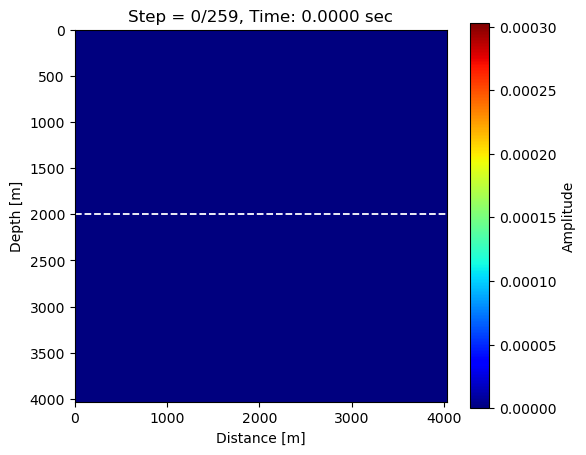

Time step: 20 	 0.0425 s


<Figure size 640x480 with 0 Axes>

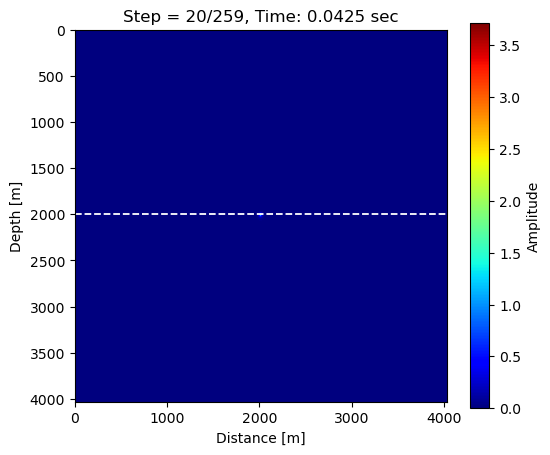

Time step: 40 	 0.0849 s


<Figure size 640x480 with 0 Axes>

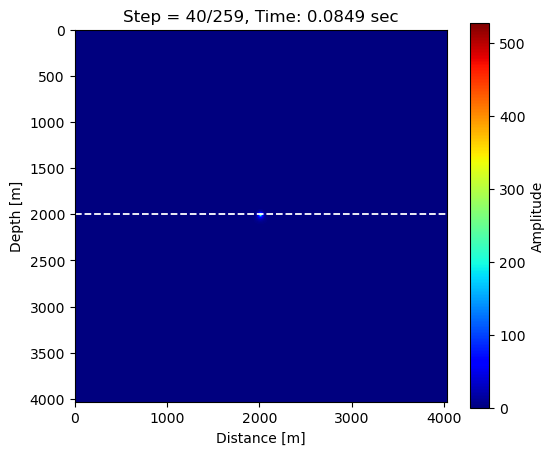

Time step: 60 	 0.1274 s


<Figure size 640x480 with 0 Axes>

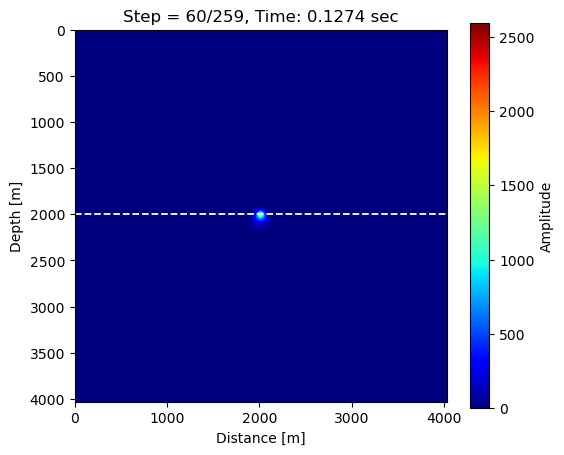

Time step: 80 	 0.1699 s


<Figure size 640x480 with 0 Axes>

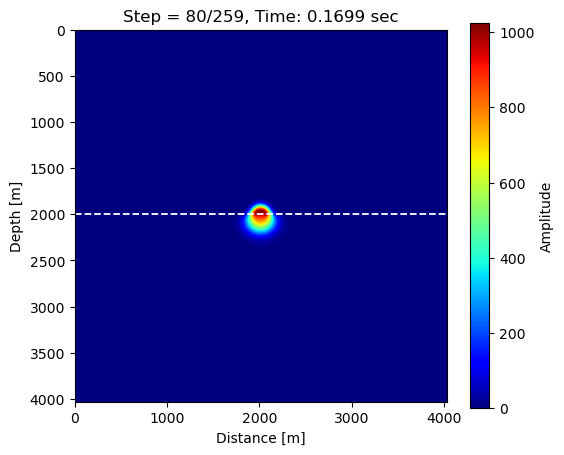

Time step: 100 	 0.2124 s


<Figure size 640x480 with 0 Axes>

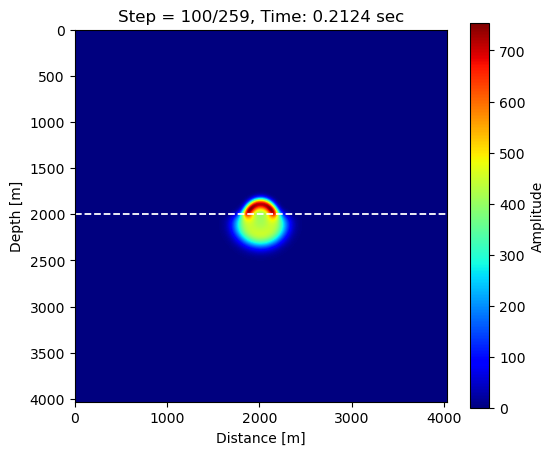

Time step: 120 	 0.2548 s


<Figure size 640x480 with 0 Axes>

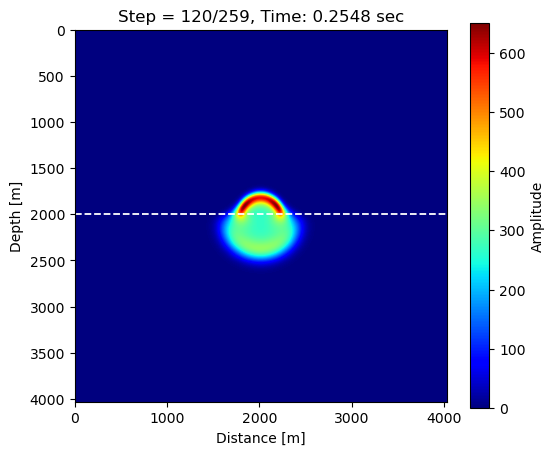

Time step: 140 	 0.2973 s


<Figure size 640x480 with 0 Axes>

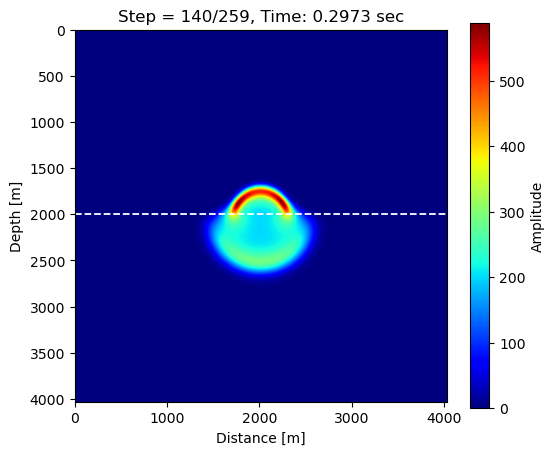

Time step: 160 	 0.3398 s


<Figure size 640x480 with 0 Axes>

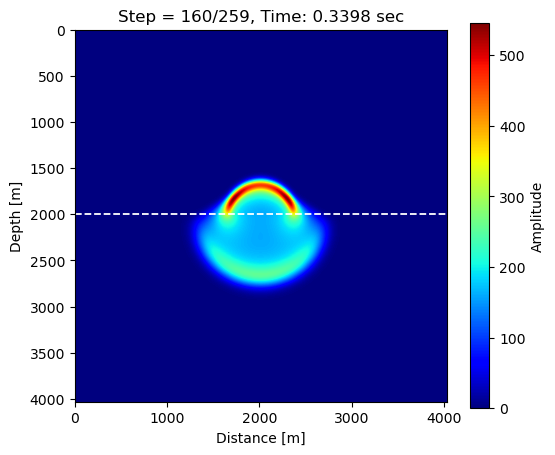

Time step: 180 	 0.3822 s


<Figure size 640x480 with 0 Axes>

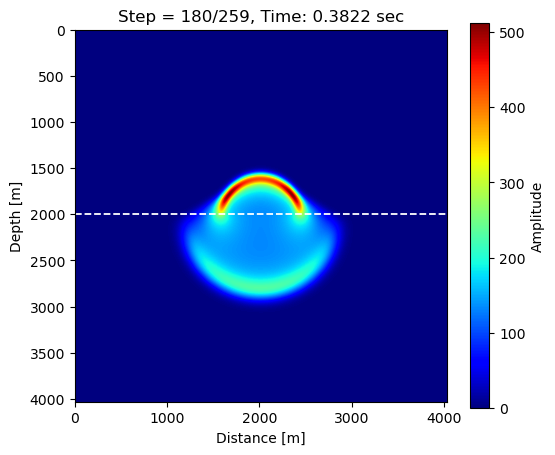

Time step: 200 	 0.4247 s


<Figure size 640x480 with 0 Axes>

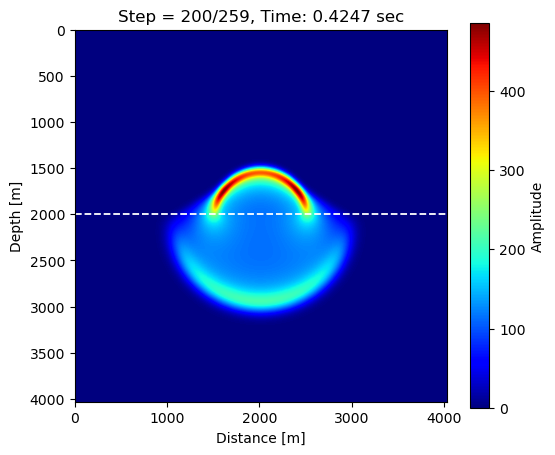

Time step: 220 	 0.4672 s


<Figure size 640x480 with 0 Axes>

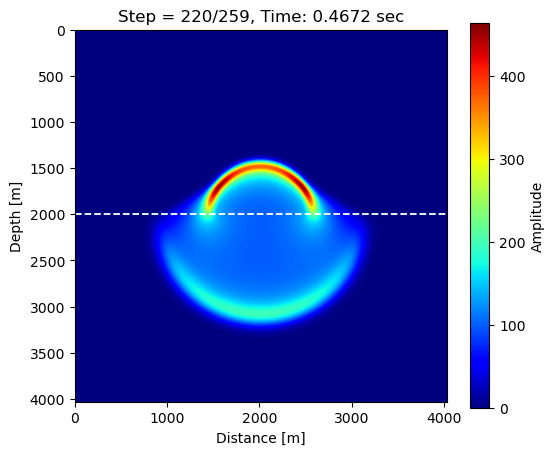

Time step: 240 	 0.5097 s


<Figure size 640x480 with 0 Axes>

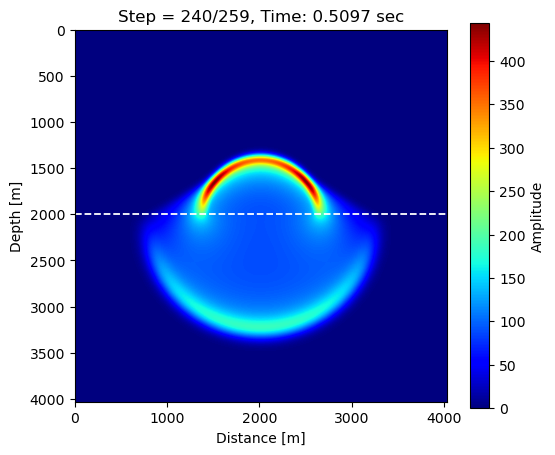

Simulation completed in 6.77 seconds
End


<Figure size 640x480 with 0 Axes>

In [4]:
# Run the simulation
if __name__ == "__main__":
    acoustic_wave_propagation()